<a href="https://colab.research.google.com/github/garry-cotton/CS909/blob/master/2023/A1/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Library imports
import numpy as np
import os
import matplotlib.pyplot as plt

1000


In [6]:
# Data load
Xtrain = np.loadtxt("Xtrain.csv").reshape(3000,28,28)
Ytrain = np.loadtxt("Ytrain.csv")

[-1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.
  1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.
 -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1

<Figure size 432x288 with 0 Axes>

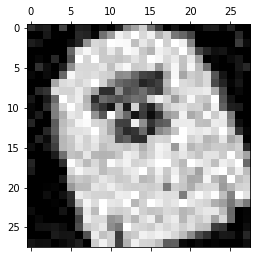

In [24]:
plt.gray(); plt.matshow(Xtrain[11])